# MCU Model Performance Analysis

This notebook visualizes the performance of deployed LIF models on MCU, showing the relationship between maximum inference frequency and angular error.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the data
data = {
    'Model': [
        'baseline', 'layers', 'channels', 'channels', 'channels', 'input resolution', 'input resolution', 'input resolution',
    ],
    'Specs': [
        '32ch., 256x256, 8l., rec.', '6 layers', '16ch.', '8ch.', '4ch.', '128x128', '64x64', '32x32',
    ],
    'N. Operations [M ops.]': [7380, 4951, 1878, 486, 129, 1845, 461, 115],
    'AEE [pixels]': [2.7, 2.9, 2.9, 3.2, 3.4, 2.76, 2.9, 2.93],
    'AAE [degrees]': [24, 29, 30, 42, 60, 44, 62, 73],
    'Static Memory Allocation [MB]': [76, 59, 38, 19, 10, 19, 5, 1]
}

df = pd.DataFrame(data)
print("Data loaded successfully:")
print(df)

Data loaded successfully:
              Model                      Specs  N. Operations [M ops.]  \
0          baseline  32ch., 256x256, 8l., rec.                    7380   
1            layers                   6 layers                    4951   
2          channels                      16ch.                    1878   
3          channels                       8ch.                     486   
4          channels                       4ch.                     129   
5  input resolution                    128x128                    1845   
6  input resolution                      64x64                     461   
7  input resolution                      32x32                     115   

   AEE [pixels]  AAE [degrees]  Static Memory Allocation [MB]  
0          2.70             24                             76  
1          2.90             29                             59  
2          2.90             30                             38  
3          3.20             42                     

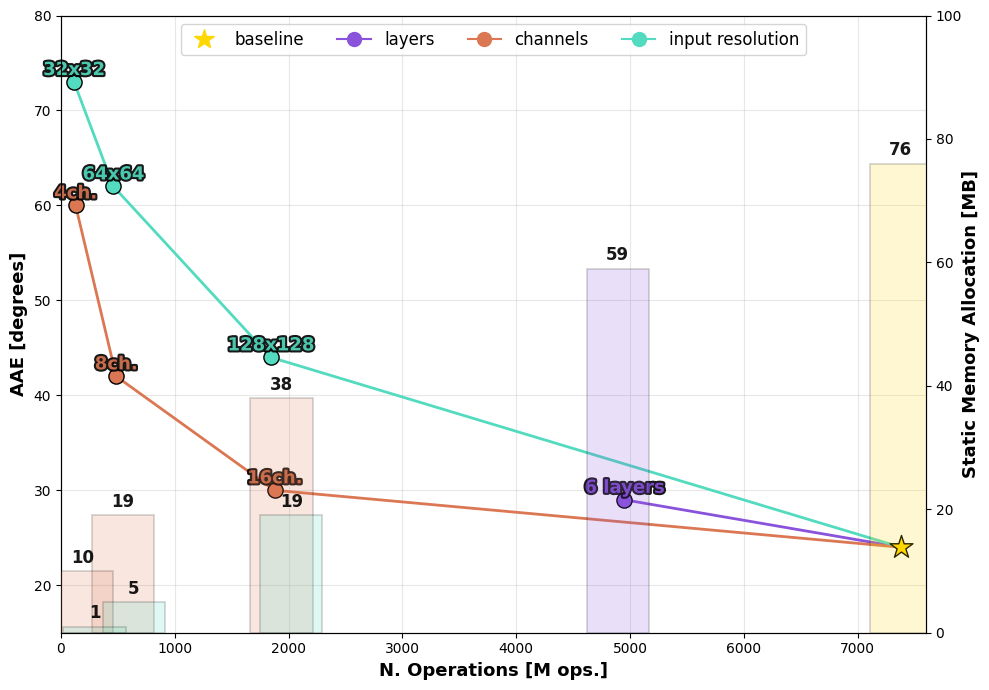

In [33]:
# Plot: x = N. Operations [M ops.], y = AAE [degrees], secondary y = Static Memory Allocation [MB] as histogram bars (wider, offset, black border, more transparent, legend upper center, labels, black bar values, enhanced dot labels, improved label separation)
import matplotlib.lines as mlines
from matplotlib.patheffects import withStroke
fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.set_facecolor('none')
fig.patch.set_alpha(0.0)

# Axes labels and limits
ax1.set_xlabel('N. Operations [M ops.]', fontsize=13, fontweight='bold')
ax1.set_ylabel('AAE [degrees]', fontsize=13, fontweight='bold')
ax1.set_xlim(0, 7600)
ax1.set_ylim(15, 80)
ax1.grid(True, alpha=0.3)

# Second y axis for memory
ax2 = ax1.twinx()
ax2.set_ylabel('Static Memory Allocation [MB]', fontsize=13, fontweight='bold', labelpad=0)
ax2.set_ylim(0, 100)

# Define model groups (excluding baseline and recurrence)
model_groups = {
    'layers': '#8A53DB',
    'channels': '#DB7753',
    'input resolution': '#53DBBF'
}

# Plot histogram bars for memory allocation (foreground, semi-transparent, wider, offset, black border, with value labels)
bar_width = 600 # even wider bars
offsets = {
    'layers': -0.5*bar_width/5,
    'channels': 0.5*bar_width/5,
    'input resolution': 1.5*bar_width/5
}
bar_handles = []
for group, color in model_groups.items():
    group_points = df[df['Model'] == group]
    x_vals = group_points['N. Operations [M ops.]'] + offsets[group]
    bars = ax2.bar(x_vals, group_points['Static Memory Allocation [MB]'],
                  width=bar_width/1.1, color=color, alpha=0.18, align='center', zorder=5, label=None, edgecolor='black', linewidth=1.2)
    bar_handles.extend(bars)
    # Add value labels on top of bars (black, larger font, closer to bar ends)
    for bar, val in zip(bars, group_points['Static Memory Allocation [MB]']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.7, f'{val}', ha='center', va='bottom', fontsize=12, color='black', fontweight='bold', alpha=0.9, zorder=6)
# Baseline bar (centered)
baseline = df[df['Model'] == 'baseline'].iloc[0]
bars = ax2.bar(baseline['N. Operations [M ops.]'], baseline['Static Memory Allocation [MB]'],
               width=bar_width/1.1, color='gold', alpha=0.18, align='center', zorder=5, label=None, edgecolor='black', linewidth=1.2)
bar_handles.extend(bars)
ax2.text(baseline['N. Operations [M ops.]'], baseline['Static Memory Allocation [MB]'] + 0.7, f"{baseline['Static Memory Allocation [MB]']}", ha='center', va='bottom', fontsize=12, color='black', fontweight='bold', alpha=0.9, zorder=6)

# Plot baseline as yellow star (foreground)
ax1.scatter(baseline['N. Operations [M ops.]'], baseline['AAE [degrees]'], marker='*', s=300, color='gold', edgecolor='black', label='baseline', zorder=10)

# For each group, plot only the first baseline and the group points (no repeated dots), and label dots with specs
label_offsets = {
    'layers': (0, 5),
    'channels': [ (0, 5), (0, 5), (0, 5) ],
    'input resolution': [(0, 5), (0, 5), (0, 5)]
}
DOT_LABEL_FONTSIZE = 13  # Increased font size for dot labels
for group, color in model_groups.items():
    group_points = df[df['Model'] == group].copy()
    group_df = pd.concat([df[df['Model'] == 'baseline'], group_points]).sort_values('N. Operations [M ops.]', ascending=False)
    # Plot line (dotted) on main axis
    ax1.plot(group_df['N. Operations [M ops.]'], group_df['AAE [degrees]'], linestyle='-', color=color, linewidth=2, label=group, zorder=2)
    # Plot dots for group points only (not baseline)
    ax1.scatter(group_points['N. Operations [M ops.]'], group_points['AAE [degrees]'], color=color, s=120, edgecolor='black', zorder=3)
    # Add labels to dots (specs) with black border and offset to avoid overlap
    if isinstance(label_offsets[group], list):
        for i, row in enumerate(group_points.itertuples()):
            dx, dy = label_offsets[group][i] if i < len(label_offsets[group]) else (0, 3 + i*2)
            ax1.annotate(row.Specs, (row._3, row._5), textcoords="offset points", xytext=(dx, dy), ha='center', fontsize=DOT_LABEL_FONTSIZE, color=color, fontweight='bold', alpha=0.9, zorder=11,
                path_effects=[withStroke(linewidth=3, foreground='black')])
    else:
        dx, dy = label_offsets[group]
        for i, row in enumerate(group_points.itertuples()):
            ax1.annotate(row.Specs, (row._3, row._5), textcoords="offset points", xytext=(dx, dy + i*2), ha='center', fontsize=DOT_LABEL_FONTSIZE, color=color, fontweight='bold', alpha=0.9, zorder=11,
                path_effects=[withStroke(linewidth=3, foreground='black')])

# Legends
star = mlines.Line2D([], [], color='gold', marker='*', linestyle='None', markersize=15, label='baseline')
dots = [mlines.Line2D([], [], color=color, marker='o', linestyle='-', markersize=10, label=label) for label, color in model_groups.items()]
ax1.legend(handles=[star]+dots, fontsize=12, loc='upper center', ncol=5)

fig.tight_layout()
plt.show()


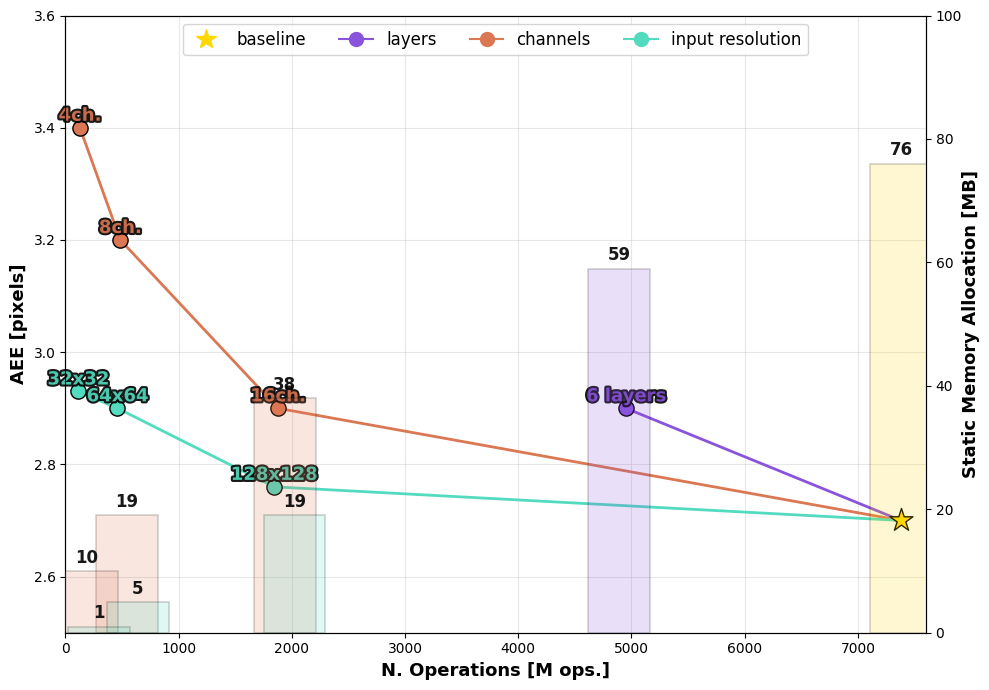

In [34]:
# Plot: x = N. Operations [M ops.], y = AEE [pixels], secondary y = Static Memory Allocation [MB] as histogram bars (wider, offset, black border, more transparent, legend upper center, labels, black bar values, enhanced dot labels, improved label separation)
import matplotlib.lines as mlines
from matplotlib.patheffects import withStroke
fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.set_facecolor('none')
fig.patch.set_alpha(0.0)

# Axes labels and limits
ax1.set_xlabel('N. Operations [M ops.]', fontsize=13, fontweight='bold')
ax1.set_ylabel('AEE [pixels]', fontsize=13, fontweight='bold')
ax1.set_xlim(0, 7600)
ax1.set_ylim(2.5, 3.6)
ax1.grid(True, alpha=0.3)

# Second y axis for memory
ax2 = ax1.twinx()
ax2.set_ylabel('Static Memory Allocation [MB]', fontsize=13, fontweight='bold', labelpad=0)
ax2.set_ylim(0, 100)

# Define model groups (excluding baseline and recurrence)
model_groups = {
    'layers': '#8A53DB',
    'channels': '#DB7753',
    'input resolution': '#53DBBF'
}

# Plot histogram bars for memory allocation (foreground, semi-transparent, wider, offset, black border, with value labels)
bar_width = 600 # even wider bars
offsets = {
    'layers': -0.5*bar_width/5,
    'channels': 0.5*bar_width/5,
    'input resolution': 1.5*bar_width/5
}
bar_handles = []
for group, color in model_groups.items():
    group_points = df[df['Model'] == group]
    x_vals = group_points['N. Operations [M ops.]'] + offsets[group]
    bars = ax2.bar(x_vals, group_points['Static Memory Allocation [MB]'],
                  width=bar_width/1.1, color=color, alpha=0.18, align='center', zorder=5, label=None, edgecolor='black', linewidth=1.2)
    bar_handles.extend(bars)
    # Add value labels on top of bars (black, larger font, closer to bar ends)
    for bar, val in zip(bars, group_points['Static Memory Allocation [MB]']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.7, f'{val}', ha='center', va='bottom', fontsize=12, color='black', fontweight='bold', alpha=0.9, zorder=6)
# Baseline bar (centered)
baseline = df[df['Model'] == 'baseline'].iloc[0]
bars = ax2.bar(baseline['N. Operations [M ops.]'], baseline['Static Memory Allocation [MB]'],
               width=bar_width/1.1, color='gold', alpha=0.18, align='center', zorder=5, label=None, edgecolor='black', linewidth=1.2)
bar_handles.extend(bars)
ax2.text(baseline['N. Operations [M ops.]'], baseline['Static Memory Allocation [MB]'] + 0.7, f"{baseline['Static Memory Allocation [MB]']}", ha='center', va='bottom', fontsize=12, color='black', fontweight='bold', alpha=0.9, zorder=6)

# Plot baseline as yellow star (foreground)
ax1.scatter(baseline['N. Operations [M ops.]'], baseline['AEE [pixels]'], marker='*', s=300, color='gold', edgecolor='black', label='baseline', zorder=10)

# For each group, plot only the first baseline and the group points (no repeated dots), and label dots with specs
label_offsets = {
    'layers': (0, 5),
    'channels': [ (0, 5), (0, 5), (0, 5) ],
    'input resolution': [(0, 5), (0, 5), (0, 5)]
}
DOT_LABEL_FONTSIZE = 13  # Increased font size for dot labels
for group, color in model_groups.items():
    group_points = df[df['Model'] == group].copy()
    group_df = pd.concat([df[df['Model'] == 'baseline'], group_points]).sort_values('N. Operations [M ops.]', ascending=False)
    # Plot line (dotted) on main axis
    ax1.plot(group_df['N. Operations [M ops.]'], group_df['AEE [pixels]'], linestyle='-', color=color, linewidth=2, label=group, zorder=2)
    # Plot dots for group points only (not baseline)
    ax1.scatter(group_points['N. Operations [M ops.]'], group_points['AEE [pixels]'], color=color, s=120, edgecolor='black', zorder=3)
    # Add labels to dots (specs) with black border and offset to avoid overlap
    if isinstance(label_offsets[group], list):
        for i, row in enumerate(group_points.itertuples()):
            dx, dy = label_offsets[group][i] if i < len(label_offsets[group]) else (0, 0.1 + i*0.1)
            ax1.annotate(row.Specs, (row._3, row._4), textcoords="offset points", xytext=(dx, dy), ha='center', fontsize=DOT_LABEL_FONTSIZE, color=color, fontweight='bold', alpha=0.9, zorder=11,
                path_effects=[withStroke(linewidth=3, foreground='black')])
    else:
        dx, dy = label_offsets[group]
        for i, row in enumerate(group_points.itertuples()):
            ax1.annotate(row.Specs, (row._3, row._4), textcoords="offset points", xytext=(dx, dy + i*0.02), ha='center', fontsize=DOT_LABEL_FONTSIZE, color=color, fontweight='bold', alpha=0.9, zorder=11,
                path_effects=[withStroke(linewidth=3, foreground='black')])

# Legends
star = mlines.Line2D([], [], color='gold', marker='*', linestyle='None', markersize=15, label='baseline')
dots = [mlines.Line2D([], [], color=color, marker='o', linestyle='-', markersize=10, label=label) for label, color in model_groups.items()]
ax1.legend(handles=[star]+dots, fontsize=12, loc='upper center', ncol=5)

fig.tight_layout()
plt.show()


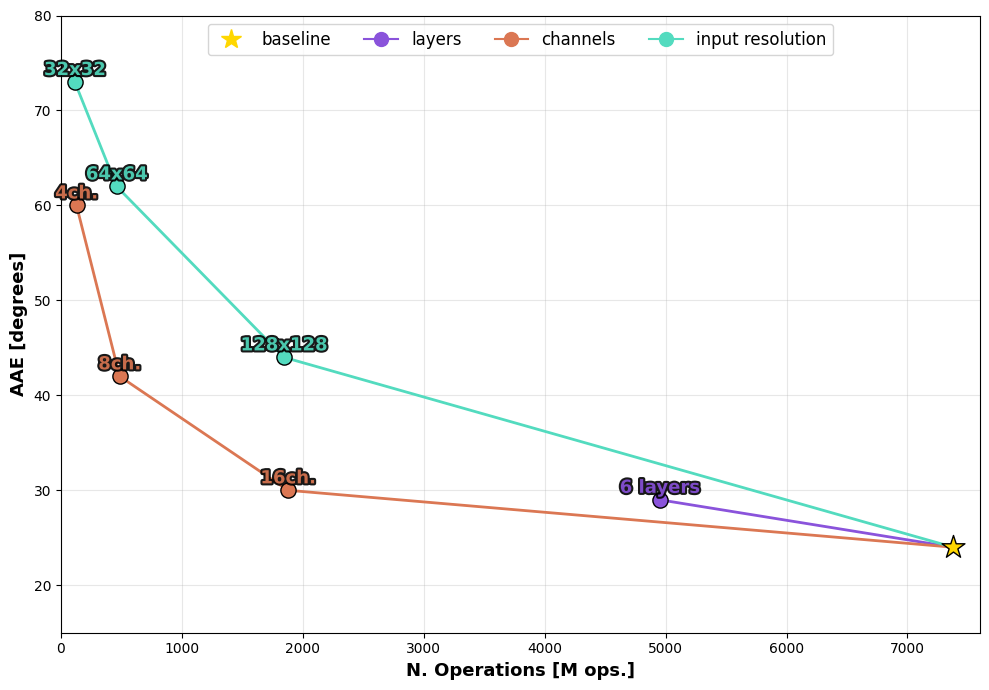

In [35]:
# NO HISTOGRAMS

# Plot: x = N. Operations [M ops.], y = AAE [degrees], secondary y = Static Memory Allocation [MB] as histogram bars (wider, offset, black border, more transparent, legend upper center, labels, black bar values, enhanced dot labels, improved label separation)
import matplotlib.lines as mlines
from matplotlib.patheffects import withStroke
fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.set_facecolor('none')
fig.patch.set_alpha(0.0)

# Axes labels and limits
ax1.set_xlabel('N. Operations [M ops.]', fontsize=13, fontweight='bold')
ax1.set_ylabel('AAE [degrees]', fontsize=13, fontweight='bold')
ax1.set_xlim(0, 7600)
ax1.set_ylim(15, 80)
ax1.grid(True, alpha=0.3)

# Define model groups (excluding baseline)
model_groups = {
    'layers': '#8A53DB',
    'channels': '#DB7753',
    'input resolution': '#53DBBF'
}

# Plot histogram bars for memory allocation (foreground, semi-transparent, wider, offset, black border, with value labels)
bar_width = 600 # even wider bars
offsets = {
    'recurrence': -1.5*bar_width/5,
    'layers': -0.5*bar_width/5,
    'channels': 0.5*bar_width/5,
    'input resolution': 1.5*bar_width/5
}

# Plot baseline as yellow star (foreground)
ax1.scatter(baseline['N. Operations [M ops.]'], baseline['AAE [degrees]'], marker='*', s=300, color='gold', edgecolor='black', label='baseline', zorder=10)

# For each group, plot only the first baseline and the group points (no repeated dots), and label dots with specs
label_offsets = {
    'recurrence': (0, 5),
    'layers': (0, 5),
    'channels': [ (0, 5), (0, 5), (0, 5) ],
    'input resolution': [(0, 5), (0, 5), (0, 5)]
}
DOT_LABEL_FONTSIZE = 13  # Increased font size for dot labels
for group, color in model_groups.items():
    group_points = df[df['Model'] == group].copy()
    group_df = pd.concat([df[df['Model'] == 'baseline'], group_points]).sort_values('N. Operations [M ops.]', ascending=False)
    # Plot line (dotted) on main axis
    ax1.plot(group_df['N. Operations [M ops.]'], group_df['AAE [degrees]'], linestyle='-', color=color, linewidth=2, label=group, zorder=2)
    # Plot dots for group points only (not baseline)
    ax1.scatter(group_points['N. Operations [M ops.]'], group_points['AAE [degrees]'], color=color, s=120, edgecolor='black', zorder=3)
    # Add labels to dots (specs) with black border and offset to avoid overlap
    if isinstance(label_offsets[group], list):
        for i, row in enumerate(group_points.itertuples()):
            dx, dy = label_offsets[group][i] if i < len(label_offsets[group]) else (0, 3 + i*2)
            ax1.annotate(row.Specs, (row._3, row._5), textcoords="offset points", xytext=(dx, dy), ha='center', fontsize=DOT_LABEL_FONTSIZE, color=color, fontweight='bold', alpha=0.9, zorder=11,
                path_effects=[withStroke(linewidth=3, foreground='black')])
    else:
        dx, dy = label_offsets[group]
        for i, row in enumerate(group_points.itertuples()):
            ax1.annotate(row.Specs, (row._3, row._5), textcoords="offset points", xytext=(dx, dy + i*2), ha='center', fontsize=DOT_LABEL_FONTSIZE, color=color, fontweight='bold', alpha=0.9, zorder=11,
                path_effects=[withStroke(linewidth=3, foreground='black')])

# Legends
star = mlines.Line2D([], [], color='gold', marker='*', linestyle='None', markersize=15, label='baseline')
dots = [mlines.Line2D([], [], color=color, marker='o', linestyle='-', markersize=10, label=label) for label, color in model_groups.items()]
ax1.legend(handles=[star]+dots, fontsize=12, loc='upper center', ncol=5)

fig.tight_layout()
plt.show()

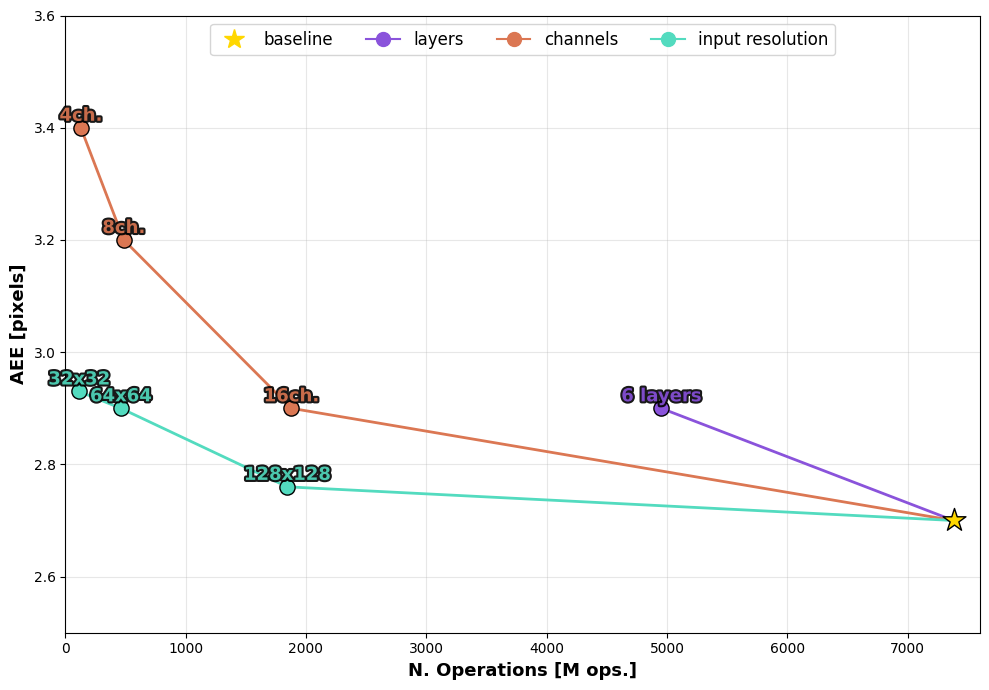

In [36]:
# NO HISTOGRAMS

# Plot: x = N. Operations [M ops.], y = AEE [pixels], secondary y = Static Memory Allocation [MB] as histogram bars (wider, offset, black border, more transparent, legend upper center, labels, black bar values, enhanced dot labels, improved label separation)
import matplotlib.lines as mlines
from matplotlib.patheffects import withStroke
fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.set_facecolor('none')
fig.patch.set_alpha(0.0)

# Axes labels and limits
ax1.set_xlabel('N. Operations [M ops.]', fontsize=13, fontweight='bold')
ax1.set_ylabel('AEE [pixels]', fontsize=13, fontweight='bold')
ax1.set_xlim(0, 7600)
ax1.set_ylim(2.5, 3.6)
ax1.grid(True, alpha=0.3)

# Define model groups (excluding baseline)
model_groups = {
    'layers': '#8A53DB',
    'channels': '#DB7753',
    'input resolution': '#53DBBF'
}

# Plot baseline as yellow star (foreground)
ax1.scatter(baseline['N. Operations [M ops.]'], baseline['AEE [pixels]'], marker='*', s=300, color='gold', edgecolor='black', label='baseline', zorder=10)

# For each group, plot only the first baseline and the group points (no repeated dots), and label dots with specs
label_offsets = {
    'recurrence': (0, 5),
    'layers': (0, 5),
    'channels': [ (0, 5), (0, 5), (0, 5) ],
    'input resolution': [(0, 5), (0, 5), (0, 5)]
}
DOT_LABEL_FONTSIZE = 13  # Increased font size for dot labels
for group, color in model_groups.items():
    group_points = df[df['Model'] == group].copy()
    group_df = pd.concat([df[df['Model'] == 'baseline'], group_points]).sort_values('N. Operations [M ops.]', ascending=False)
    # Plot line (dotted) on main axis
    ax1.plot(group_df['N. Operations [M ops.]'], group_df['AEE [pixels]'], linestyle='-', color=color, linewidth=2, label=group, zorder=2)
    # Plot dots for group points only (not baseline)
    ax1.scatter(group_points['N. Operations [M ops.]'], group_points['AEE [pixels]'], color=color, s=120, edgecolor='black', zorder=3)
    # Add labels to dots (specs) with black border and offset to avoid overlap
    if isinstance(label_offsets[group], list):
        for i, row in enumerate(group_points.itertuples()):
            dx, dy = label_offsets[group][i] if i < len(label_offsets[group]) else (0, 0.1 + i*0.1)
            ax1.annotate(row.Specs, (row._3, row._4), textcoords="offset points", xytext=(dx, dy), ha='center', fontsize=DOT_LABEL_FONTSIZE, color=color, fontweight='bold', alpha=0.9, zorder=11,
                path_effects=[withStroke(linewidth=3, foreground='black')])
    else:
        dx, dy = label_offsets[group]
        for i, row in enumerate(group_points.itertuples()):
            ax1.annotate(row.Specs, (row._3, row._4), textcoords="offset points", xytext=(dx, dy + i*0.02), ha='center', fontsize=DOT_LABEL_FONTSIZE, color=color, fontweight='bold', alpha=0.9, zorder=11,
                path_effects=[withStroke(linewidth=3, foreground='black')])

# Legends
star = mlines.Line2D([], [], color='gold', marker='*', linestyle='None', markersize=15, label='baseline')
dots = [mlines.Line2D([], [], color=color, marker='o', linestyle='-', markersize=10, label=label) for label, color in model_groups.items()]
ax1.legend(handles=[star]+dots, fontsize=12, loc='upper center', ncol=5)

fig.tight_layout()
plt.show()

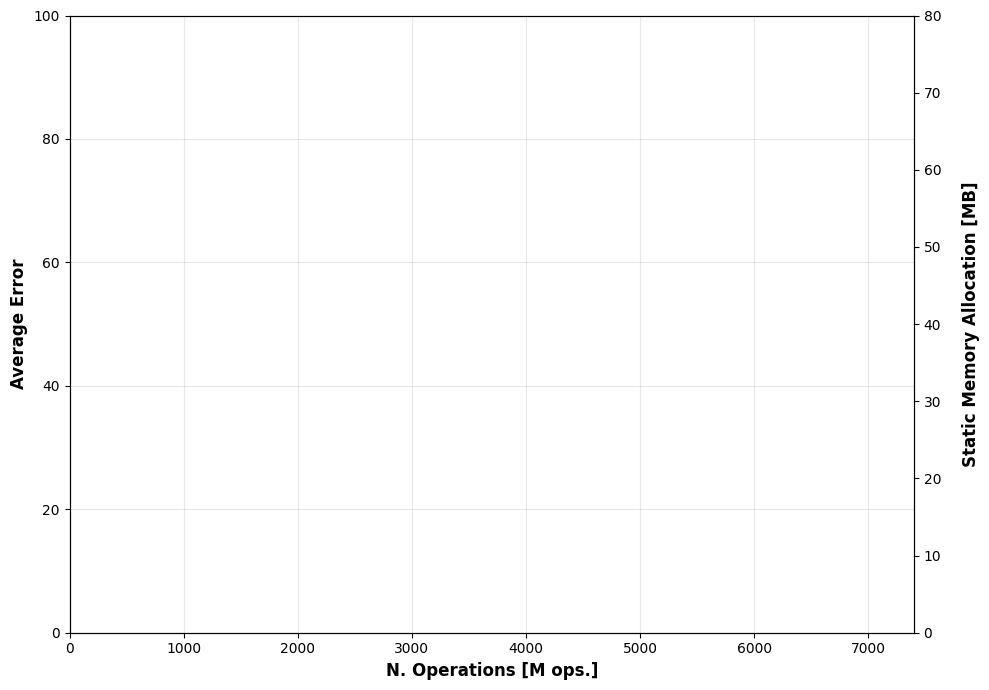

In [37]:
# Empty graph to show only axes, with a second y axis for Static Memory Allocation [MB]
fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.set_facecolor('none')
fig.patch.set_alpha(0.0)
ax1.set_xlabel('N. Operations [M ops.]', fontsize=12, fontweight='bold')
ax1.set_ylabel('Average Error', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 7400)
ax1.set_ylim(0, 100)
ax1.grid(True, alpha=0.3)

# Create second y axis
ax2 = ax1.twinx()
ax2.set_ylabel('Static Memory Allocation [MB]', fontsize=12, fontweight='bold', labelpad=15)
ax2.set_ylim(0, 80)

fig.tight_layout()
plt.show()